## Semantic Lung segmentation with the U-Net architecture

### Introduction
This notebook demonstrates a deep learning approach for semantic segmentation of lung X-ray images. The goal is to classify pixels in X-ray images into two classes: COVID-19 affected regions and normal lung tissue. We'll use a U-Net architecture with dropout regularization to train the model. The U-Net architecture is depicted in the figure below.

### Dataset
The dataset consists of X-ray images and the corresponding masks. The images and masks are loaded using a custom dataset class, and transformations are applied for preprocessing.

### Model Architecture
The semantic segmentation model is built using a UNet architecture, combining the power of downsampling and convolutional operations. The model is trained with a Dice Loss and Adam optimizer. The classical U-Net architecture is shown below.

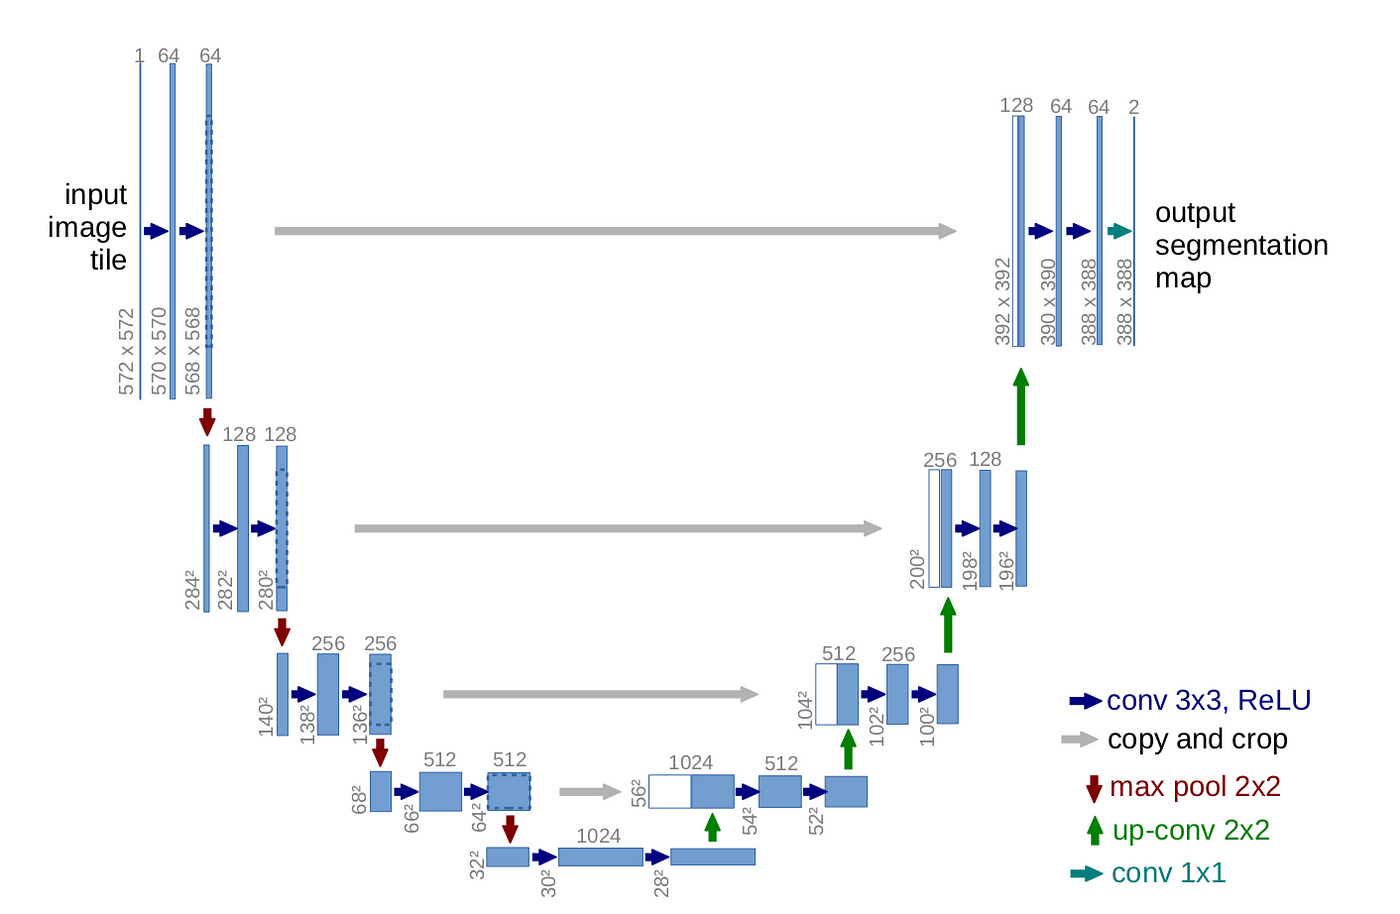

### Training and Evaluation
The notebook includes functions for training the model, visualization of training samples, and evaluation metrics computation. Early stopping is employed to prevent overfitting.

### Results
The trained model is loaded, and examples from the validation and test sets are visualized. Metrics such as accuracy, IoU, F1 score, precision, and recall are computed for assessing the model's performance.

Feel free to explore the code cells for a detailed walkthrough of the implementation and insights into semantic segmentation with ResNetUNet.

### Import necesssary libraries for image processing, deep learning, and visualization

In [ ]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

try:
    import segmentation_models_pytorch as smp
except ImportError:
    !pip install segmentation-models-pytorch -q > /dev/null
    import segmentation_models_pytorch as smp

### Dataset, Data Loading and Preprocessing
We start by importing necessary libraries and defining a custom dataset class LungDataset to load and preprocess the lung X-ray images and their corresponding masks. The dataset is divided into training, validation, and test sets. We also define transformations to resize and normalize the images and masks.

In [ ]:
class LungDataset(Dataset):
    def __init__(self, data_paths, transform=None, augmentations=None):
        self.data_paths = sorted(data_paths)
        self.transform = transform
        self.augmentations = augmentations
        
        self.images = []
        self.masks = []
        
        # Loop over data paths
        for data_path in self.data_paths:
            image_path = os.path.join(data_path, "images")
            mask_path = os.path.join(data_path, "masks")
            
            # Load images and masks
            images = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith(".png")]
            masks = [os.path.join(mask_path, f) for f in os.listdir(mask_path) if f.endswith(".png")]

            self.images.extend(sorted(images))
            self.masks.extend(sorted(masks))
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = self.images[idx]
        mask_path = self.masks[idx]

        # Open images and masks
        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")  # Convert to grayscale mask
        
        if self.transform:
            image, mask = self.transform(image, mask)
            
        if self.augmentations:
            image, mask = self.augmentations(image, mask)
        
        return image, mask

### Define Image and Mask Transformations

In [ ]:
def transform(image, mask):
    image_transform = transforms.Compose([
        transforms.Resize(size=PATCH_SIZE, antialias=True),
        transforms.ToTensor()
    ])
    
    mask_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=PATCH_SIZE, antialias=False)
    ])
    
    return image_transform(image), mask_transform(mask).type(torch.int)

### Create Dataset and DataLoader Instances

In [ ]:
PATCH_SIZE = (256, 256)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16

data_path = ["/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/",
             "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity",
             "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal",
             "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia"]

dataset = LungDataset(data_path, transform=transform, augmentations=None)

# Define the sizes for each split
dataset_size = len(dataset)
test_size = int(0.15 * dataset_size)
val_size  = int(0.15 * dataset_size)
train_size = dataset_size - test_size - val_size

# Use random_split to create train, test, and val datasets
train_dataset, temp_dataset = random_split(dataset, [train_size, test_size + val_size], generator=torch.Generator().manual_seed(42))
test_dataset, val_dataset = random_split(temp_dataset, [test_size, val_size], generator=torch.Generator().manual_seed(42))

# train_dataset.augmentations = train_augmentations

# Create DataLoader instances for each set
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

### Visualize some samples

In [ ]:
# Function to visualize images and masks
def visualize_samples(dataset, num_samples=5):
    # Visualize the images and masks
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2 * num_samples))
    for i in range(num_samples):
        image, mask = dataset[np.random.randint(len(dataset))]
        
        # Display images
        axes[i, 0].imshow(image.cpu().permute(1,2,0))
        axes[i, 0].set_title(f'Sample {i + 1} - Image')
        axes[i, 0].axis('off')

        # Display masks
        axes[i, 1].imshow(mask.cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title(f'Sample {i + 1} - Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize samples from the train dataset
visualize_samples(train_dataset)

### Model Definition
Next, we define the U-Net model architecture for semantic segmentation. The model consists of an encoder-decoder architecture with skip connections, facilitating the precise localization of features. Dropout layers are added to mitigate overfitting.

### Define UNet Components (Up, DoubleConv, OutConv)

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, dropout_rate=0.1):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2, dropout_rate=dropout_rate)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, dropout_rate=dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

### Define UNet Model

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False, dropout_rate=0.1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64, dropout_rate=dropout_rate))
        self.down1 = (Down(64, 128, dropout_rate=dropout_rate))
        self.down2 = (Down(128, 256, dropout_rate=dropout_rate))
        self.down3 = (Down(256, 512, dropout_rate=dropout_rate))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor, dropout_rate=dropout_rate))
        self.up1 = (Up(1024, 512 // factor, bilinear, dropout_rate=dropout_rate))
        self.up2 = (Up(512, 256 // factor, bilinear, dropout_rate=dropout_rate))
        self.up3 = (Up(256, 128 // factor, bilinear, dropout_rate=dropout_rate))
        self.up4 = (Up(128, 64, bilinear, dropout_rate=dropout_rate))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Instantiate Model 

In [ ]:
unet = UNet(1, 2, bilinear=False, dropout_rate=0.1).to(DEVICE)

# unet = nn.DataParallel(unet)
# unet.load_state_dict(torch.load("/kaggle/input/covid-19-unet/pytorch/unet-model-segmentation-1/1/best_model.pth"))

### Training Setup
We set up the training process by defining the loss function, optimizer, and learning rate scheduler. We'll use the Dice Loss function for multi-class segmentation and the Adam optimizer. Additionally, we set up a learning rate scheduler to adjust the learning rate based on validation loss. Early stopping criteria are also defined to prevent overfitting.

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define constants
LEARNING_RATE = 0.001
LR_FACTOR = 0.5
LR_PATIENCE = 2
EARLY_STOP_PATIENCE = 4
NUM_EPOCHS = 25

# Define the loss function, optimizer, and learning rate scheduler
criterion = smp.losses.DiceLoss('multiclass')
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience=LR_PATIENCE, verbose=False)

# Initialize early stopping parameters
early_stop_counter = 0
best_val_loss = float('inf')

### Train the model

In [ ]:
from tqdm import tqdm
from torch.nn.parallel import DataParallel

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, early_stop_patience=4):
    best_val_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    val_losses = []

    model = DataParallel(model)
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, masks) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(DEVICE), masks.to(DEVICE, dtype=torch.long)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        # Print and check for early stopping
        print(f'Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f'Early stopping after {early_stop_patience} epochs without improvement.')
            break

    return train_losses, val_losses

# Now, call the function with your specific parameters
train_model(unet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, early_stop_patience=EARLY_STOP_PATIENCE)

# Load the best model after training
unet = nn.DataParallel(unet) # this is necessary to get matching key dicts
unet.load_state_dict(torch.load('best_model.pth'))

### Evaluation
After training, we evaluate the trained model on the test set to assess its generalization performance. We visualize sample predictions to gain insights into the model's segmentation capabilities.

### Plot Examples from Test Dataset

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Function to plot examples with predicted and true masks
def plot_examples(model, dataset, num_examples=5):
    model.eval()
    
    for i in range(num_examples):
        image, mask = dataset[i]
        
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(DEVICE)).cpu()
        
        pred_mask = torch.argmax(output, dim=1)
        
        # Plot the images and masks
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('True Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.permute(1,2,0), cmap='gray')
        plt.axis("off")
        plt.title('Predicted Mask')
        
        plt.tight_layout()
        plt.show()

# Plot examples from the test dataloader
plot_examples(unet, test_dataset, num_examples=10)

### Compute metrics for test, train and validation datasets

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, jaccard_score, f1_score, precision_score, recall_score

def compute_metrics(model, dataloader):
    model.eval()
    
    all_true_masks = []
    all_pred_masks = []
    
    confusion = np.zeros((2,2))
    for images, masks in tqdm(dataloader, total=len(dataloader)):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(images)
        
        # Convert probability maps to binary masks using a threshold
        pred_masks = torch.argmax(outputs, dim=1)
        
        true_masks_np = masks.cpu().detach().numpy().ravel()
        pred_masks_np = pred_masks.cpu().detach().numpy().ravel()
        
        confusion += confusion_matrix(true_masks_np, pred_masks_np)
    
    # Calculate metrics
    TN, FP, FN, TP = confusion.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    jaccard_index = TP / (TP + FP + FN)

    print(f"  Accuracy : {accuracy:.4f}")
    print(f"  IoU      : {jaccard_index:.4f}")
    print(f"  F1 Score : {f1_score:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")

# Ensure DEVICE variable is defined
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Compute metrics for validation set
print("\nMetrics for Validation Set:")
compute_metrics(unet, val_loader)

# Compute metrics for test set (replace test_loader with your actual test dataloader)
print("\nMetrics for Test Set:")
compute_metrics(unet, test_loader)


### Conclusion
In this notebook, we successfully trained a U-Net model for semantic segmentation of lung X-ray images. The model demonstrates promising performance in classifying COVID-19 affected regions and normal lung tissue. Further optimizations and fine-tuning can be explored to enhance the model's performance further.

### Your Thoughts?
That's a wrap! 🎉 What are your impressions? Any suggestions or tweaks to make this model even cooler? Drop your thoughts in the comments! Whether it's about the code, visualizations, or potential improvements, I'm all ears.